# Krypton S12 selection

### Run 5858: 15-06-2018 
- no sources, high lifetime
- pressure: 10 bar
- Gate voltage: 8 kV

### Selection of events in terms of S1 and S2

In [1]:
import os
import time
import glob

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers

from icaro.core.fit_functions import fit_slices_1d_gauss
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [73]:
import core.kr_s1s2_functions as krc
import core.kr_fit_functions as krf
import core.kr_histo_functions as krh
import core.kr_plt_functions as krp

In [34]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from   invisible_cities.evm  .ic_containers  import Measurement

In [68]:
from icaro.core.fit_functions import to_relative
from   invisible_cities.types.ic_types import minmax

### Init

In [3]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/kdst"
run_number          = 5858
input_dst_filenames = f"{path}/{run_number}/kdst*.h5"
input_dst_filename  = f"{path}/{run_number}/kdst_{run_number}.h5"

print(f"run number = {run_number}")
print(f"input dsts = {input_dst_filenames}")


run number = 5858
input dsts = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5858/kdst*.h5


In [4]:
output_dst_filename  = f"{path}/{run_number}/kdst_{run_number}_s1s2.h5"
print(f"output dst = {output_dst_filename}")

output dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5858/kdst_5858_s1s2.h5


In [5]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Mon Jun 18 21:02:46 2018


In [6]:
#dst_full           = dstf.load_dst(input_dst_filename, "DST", "Events")
dst_full           = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1971280 
Total number of events: 1179463


In [7]:
dst_full.columns

Index(['DT', 'Nsipm', 'Phi', 'R', 'S1e', 'S1h', 'S1t', 'S1w', 'S2e', 'S2h',
       'S2q', 'S2t', 'S2w', 'X', 'Xrms', 'Y', 'Yrms', 'Z', 'Zrms', 'event',
       'index', 'nS1', 'nS2', 's1_peak', 's2_peak', 'time'],
      dtype='object')

In [8]:
ntot = len(dst_full)

 0S2/tot  = 0.0 1S2/tot = 1.0 2S2/tot = 0.0


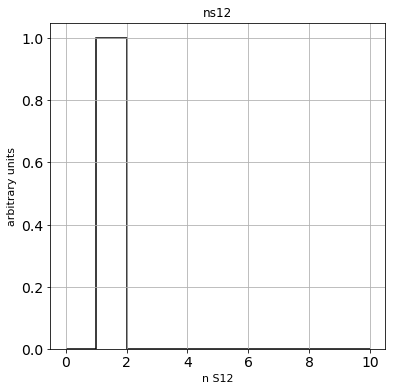

In [42]:
krc.ns12(dst_full, type='S1')

 0S2/tot  = 0.0 1S2/tot = 0.8830511139969969 2S2/tot = 0.1005346779757315


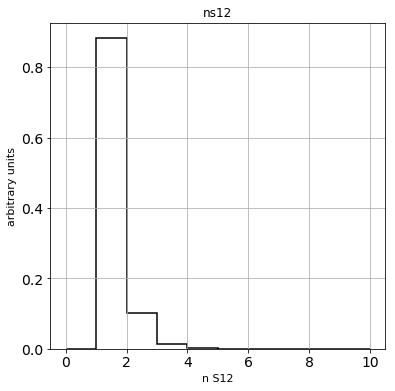

In [43]:
krc.ns12(dst_full, type='S2')

In [45]:
krc.print_ns12_stats(*krc.ns1_stats(dst_full))

ns12: mean =  1.00 sigma =  0.00
ns12 : fraction
0:  0.00
1:  1.00
2:  0.00
3:  0.00
4:  0.00


In [46]:
krc.print_ns12_stats(*krc.ns2_stats(dst_full))

ns12: mean =  1.13 sigma =  0.39
ns12 : fraction
0:  0.00
1:  0.88
2:  0.10
3:  0.01


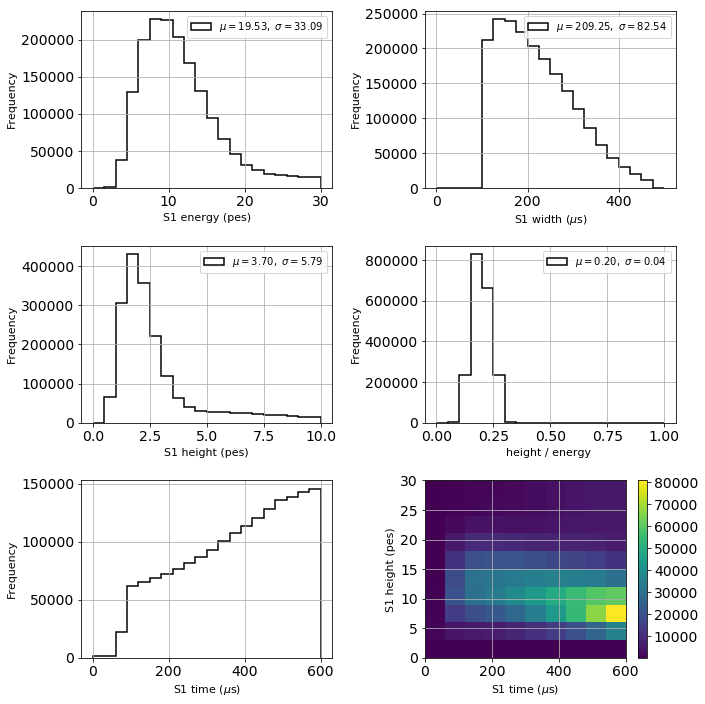

In [47]:
krc.plot_s1histos(dst_full, bins=20, figsize=(10,10))

## Select events with only 1 s1

In [48]:
dst1s1 = dst_full[dst_full.nS1==1]

### Select a single S2

In [49]:
dst1s12 = dst1s1[dst1s1.nS2==1]

In [50]:
dst = dst1s12
number_of_events  = len(dst)
eff = number_of_events  / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {number_of_events}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1740741: selection eff = 0.8830511139969969 


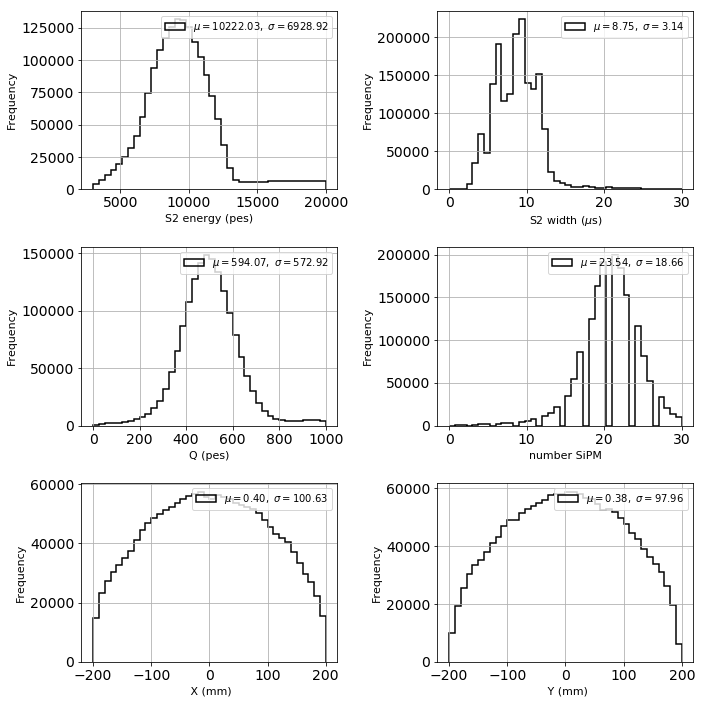

In [51]:
krc.plot_s2histos(dst1s12, bins=40, emin=3000, emax=20000, figsize=(10,10))

In [52]:
dst = dst1s12
number_of_events  = len(dst)
eff = number_of_events  / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {number_of_events}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1740741: selection eff = 0.8830511139969969 


In [53]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values

krEvent = KrEvent(X = dst.X.values,
                  Y = dst.Y.values,
                  Z = dst.Z.values,
                  E = dst.S2e.values,
                  Q = dst.S2q.values)

### Ranges and binning

In [77]:
Zrange  =  100,  550
XYrange = -200,  200
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   50
Enbins  =  50
Qnbins  =  50

Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

In [78]:
krNBins  = KrNBins(E = Enbins, Q = Qnbins, Z = Znbins, XY = XYnbins)
krRanges = KrRanges(E = Erange, Q = Qrange, Z = Zrange, XY = XYrange)
krBins   = KrBins(E = Ebins, Q = Qbins, Z = Zbins, XY = XYbins, cXY = XYcenters) 

### Event distribution

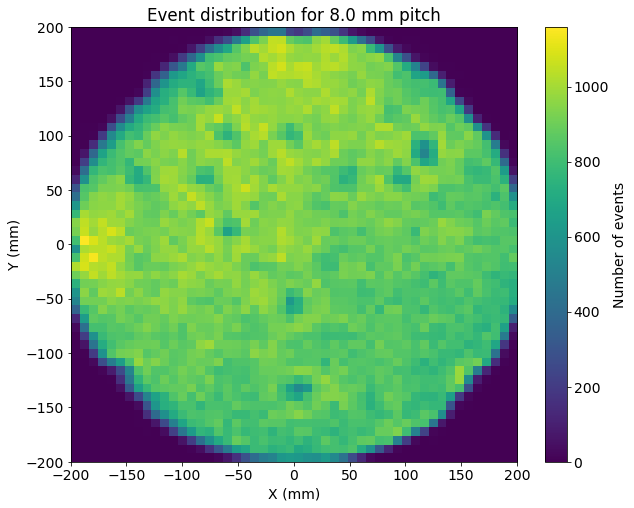

In [79]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

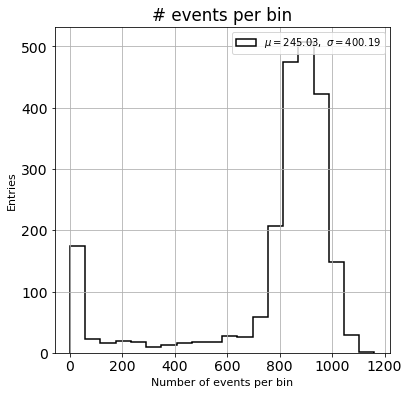

In [80]:
nevt_max = int(np.max(nevt))
mu, sigma = krh.h1d(nevt.flatten(), bins=20, range=(1, nevt_max + 2),
        xlabel='Number of events per bin', ylabel='Entries',
        title="# events per bin", legend = 'upper right',)

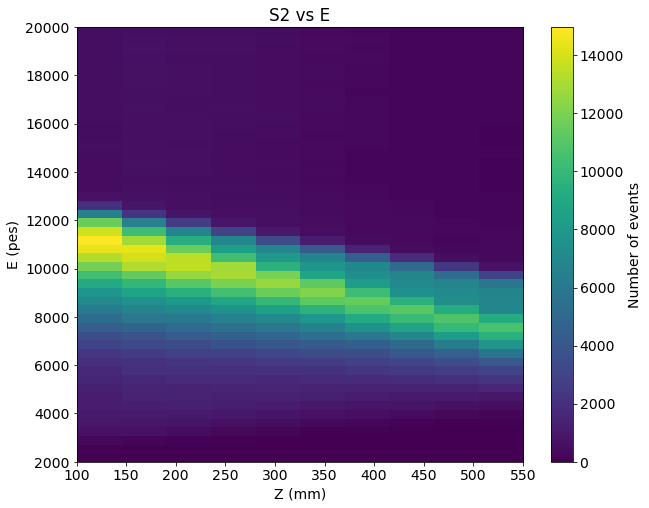

In [95]:
nevt, *_ = plt.hist2d(Z, E, (Zbins, Ebins))
plt.colorbar().set_label("Number of events")
labels("Z (mm)", "E (pes)", f"S2 vs E")

### Fit examples

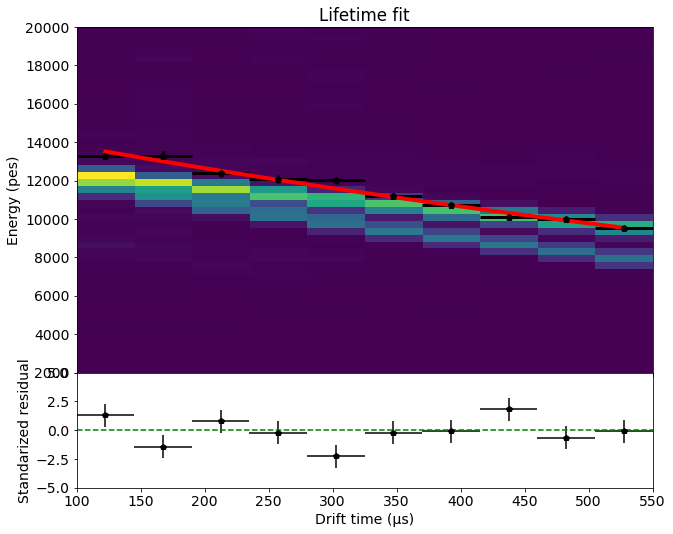

In [81]:
xlim =  -25, 25
ylim =  -25, 25
xyr = XYRanges(X=xlim, Y=ylim )

kf = krf.lifetime_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr)

In [82]:
krf.print_fit(kf)

 E (z=0) = 15012.491631671697 +-172.69445168428368 
 LT      = -1165.1199658521432 +-40.26935918096468 
 chi2    = 1.1066705092113742 


xlim = (-125, -75), ylim =(-125, -75)
 E (z=0) = 13563.914925535566 +-136.8577714757001 
 LT      = -1098.8374633776964 +-32.861734396962724 
 chi2    = 1.2502547014906886 
xlim = (-125, -75), ylim =(75, 125)
 E (z=0) = 12497.59162246206 +-138.37521621084605 
 LT      = -1133.9463834990859 +-43.38602692588442 
 chi2    = 1.0387855860339752 
xlim = (75, 125), ylim =(75, 125)
 E (z=0) = 11888.215435448601 +-130.66475030588552 
 LT      = -1208.796436099457 +-43.69694683560776 
 chi2    = 1.8325338546261043 
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11768.945903797394 +-107.66196714343528 
 LT      = -1488.9726108581917 +-62.723630108475284 
 chi2    = 0.9137330978689054 


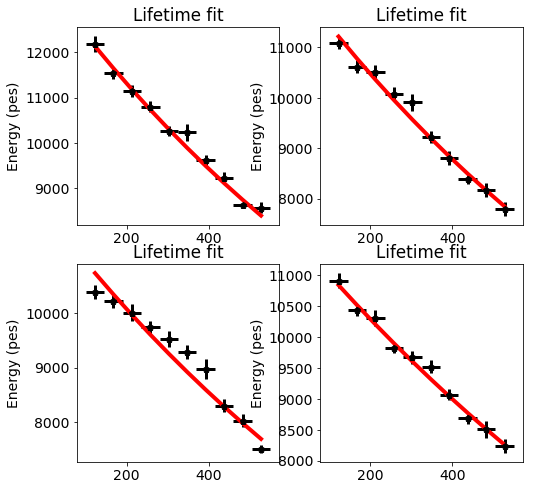

In [83]:
krf.lifetimes_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))

In [84]:
krfs = krf.fit_lifetime_slices(krEvent, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [85]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [86]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.7024

In [87]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =1295.7244681090622 +- 560.7604702644574
Lifetime uncertainty     : mu +- std =13.936607854130536 +- 7.984980345993202
Energy scale value       : mu +- std =12061.650152094993 +- 1539.9243289592503
Energy scale uncertainty : mu +- std =3.5150378822796267 +- 1.506598719950972


In [88]:
n_sigma  = 1.5
u_sigma  = 1.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 9751.763658656118; E_max = 14371.536645533868
 Lifetime (ELT): ELT_min = 454.58376271237614; ELT_max = 2136.8651735057483
 Energy scale error (Eu): Eu_min = 1.2551398023531686; Eu_max = 5.774935962206085
 Lifetime error (ELTu): ELTu_min = 1.9591373351407313; ELTu_max = 25.91407837312034


### Map display

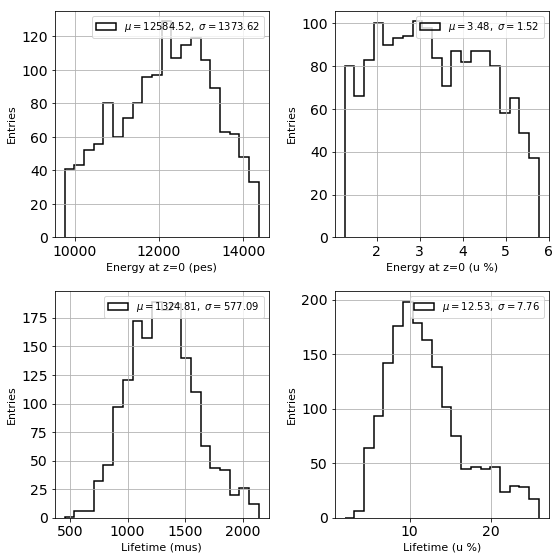

In [89]:
krh.h1d_4((Escale.value[valid],Escale.uncertainty[valid],
          ELT.value[valid],ELT.uncertainty[valid]),
          (20,20,20,20),
          (kltl.Es.interval,kltl.Eu.interval,kltl.LT.interval,kltl.LTu.interval),
          ('Energy at z=0 (pes)','Energy at z=0 (u %)','Lifetime (mus)', 'Lifetime (u %)'),
          ('Entries','Entries','Entries','Entries'),
          titles  =None,
          legends = ('best','best','best','best'),
          figsize =(8,8))

In [90]:
invalid = ~valid
mask = valid

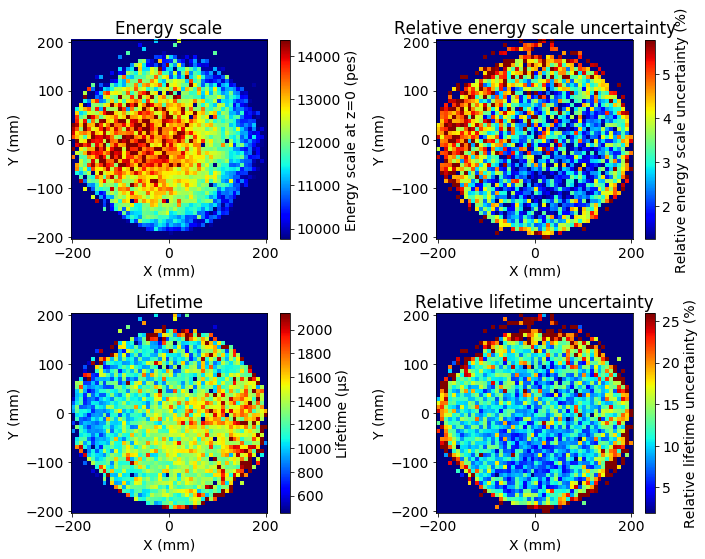

In [91]:
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=valid)

(1.2915859546937238, 0.60741723871548536)

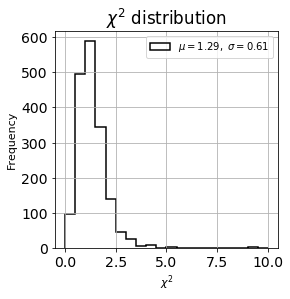

In [92]:
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

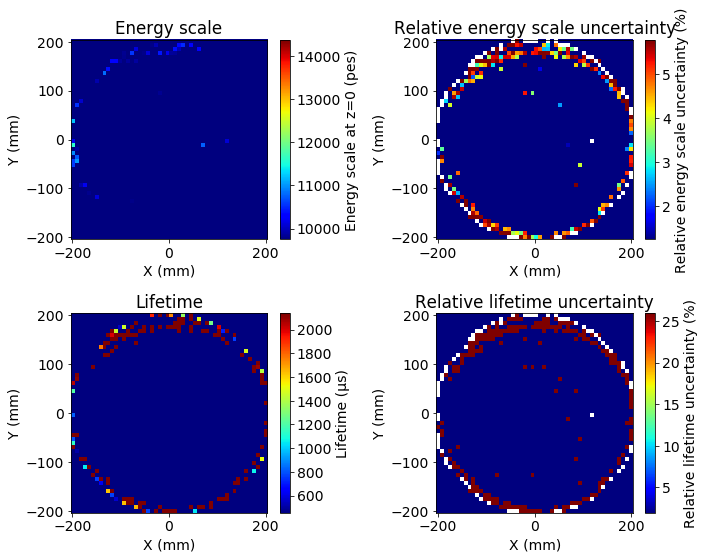

In [93]:
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=invalid)

In [31]:
dst.to_hdf(output_dst_filename, key     = "DST", mode         = "w",
          format  = "table", complib = "zlib" , complevel    = 4)

In [23]:
# Unfortunately, this method can't set a specific name to the table or its title.
# It also includes an extra column ("index") which I can't manage to remove.
dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)



IndexError: tuple index out of range

In [32]:
# Workaround to re-establish the name of the table and its title
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"